In [81]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Generator, Union
from tensorflow import Tensor, GradientTape, function, concat, ones, zeros, random, cast
from tensorflow.keras.layers import Conv2D, ReLU, BatchNormalization, add, Input, UpSampling2D, LeakyReLU, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy, mean_squared_error
from tensorflow.keras.optimizers import Adam

In [82]:
def generator_net(input_shape: tuple, res_num: int = 1) -> Model:
    """
    Srgan生成器网络

    :param input_shape: 输入图像形状
    :param res_num: 残差块个数
    :return: 生成器网络
    """

    def res_block(y_) -> Tensor:
        """
        残差网络块

        :param y_: 输入
        :return:
        """
        for i in range(res_num):
            _y = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(y_)
            _y = BatchNormalization()(_y)
            _y = ReLU()(_y)
            _y = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(_y)
            _y = BatchNormalization()(_y)
            y_ = add([_y, y_])
        return y_

    x = Input(shape=input_shape)

    # head
    y = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(x)
    y = ReLU()(y)

    # body
    y = res_block(y)

    # leg
    y = UpSampling2D(size=2)(y)
    y = ReLU()(y)

    y = UpSampling2D(size=2)(y)
    y = ReLU()(y)

    y = Conv2D(filters=input_shape[-1], kernel_size=(3, 3), padding="same")(y)
    return Model(inputs=x, outputs=y)

In [83]:
def discriminator_net(input_shape: tuple) -> Model:
    """
    判决器网络

    :param input_shape: 图片输入形状
    :return: 判决器网络
    """
    x = Input(shape=input_shape)

    y = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(x)
    y = LeakyReLU()(y)

    y = Conv2D(filters=64, kernel_size=(3, 3), padding="same", strides=2)(y)
    y = LeakyReLU()(y)
    y = BatchNormalization()(y)

    y = Conv2D(filters=128, kernel_size=(3, 3), padding="same", strides=2)(y)
    y = LeakyReLU()(y)
    y = BatchNormalization()(y)
    y = Conv2D(filters=256, kernel_size=(3, 3), padding="same", strides=2)(y)
    y = LeakyReLU()(y)
    y = BatchNormalization()(y)

    y = Dense(512)(y)
    y = LeakyReLU()(y)
    y = Dense(1)(y)
    y = sigmoid(y)
    return Model(inputs=x, outputs=y)

In [84]:
gen = generator_net((32, 32, 3))
gen_opt = Adam(learning_rate=0.0004)
gen.summary()

Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_84 (Conv2D)              (None, 32, 32, 64)   1792        input_28[0][0]                   
__________________________________________________________________________________________________
re_lu_36 (ReLU)                 (None, 32, 32, 64)   0           conv2d_84[0][0]                  
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 32, 32, 64)   36928       re_lu_36[0][0]                   
___________________________________________________________________________________________

In [85]:
dis = discriminator_net((128, 128, 3))
dis_opt = Adam(learning_rate=0.0003)
dis.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 32, 32, 128)       738

In [86]:
def img_to_one(img: Union[Tensor, np.ndarray]):
    """
    归一化

    :param img:
    :return:
    """
    return (img / 255. - 0.5) * 2.

def reverse_img(img: Tensor):
    """
    图片还原

    :param img:
    :return:
    """
    img = cast(img, dtype="int32")
    return (img + 1) * 255 / 2

def data_loader(img_path: str, batch_size: int) -> Generator:
    img_list = list(Path(img_path).iterdir())
    batch_num = len(img_list) // batch_size
    np.random.shuffle(img_list)
    batch_hr_img_data = []
    batch_lr_img_data = []
    for num in range(1, batch_size * batch_num + 1):
        _img = cv2.cvtColor(cv2.resize(cv2.imread(str(img_list[num]), cv2.IMREAD_COLOR),
                                       (128, 128)), cv2.COLOR_BGR2RGB)
        batch_hr_img_data.append(_img)
        batch_lr_img_data.append(cv2.resize(_img, (32, 32), cv2.INTER_LINEAR))
        if num % batch_size == 0:
            hr_data = img_to_one(np.array(batch_hr_img_data, dtype="float32"))
            lr_data = img_to_one(np.array(batch_lr_img_data, dtype="float32"))
            batch_hr_img_data.clear()
            batch_lr_img_data.clear()
            yield hr_data, lr_data, f'{num} / {batch_size * batch_num + 1}'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


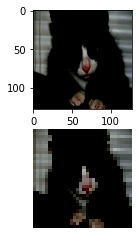

In [87]:
a, b, _ = next(data_loader('../data/training_set/cats', 1))
plt.figure()
plt.subplot(2, 1, 1)
plt.imshow(a[0])
plt.subplot(2, 1, 2)
plt.imshow(b[0])
plt.axis("off")
plt.show()

def show_pic(real_img, fake_img):
    plt.figure()
    plt.axis("off")
    plt.subplot(2, 1, 1)
    plt.imshow(real_img[0])
    plt.subplot(2, 1, 2)
    plt.imshow(fake_img[0])
    plt.show()

In [88]:
bc = BinaryCrossentropy(from_logits=False)
vgg16 = VGG16(include_top=False)
vgg16.trainable = False
dis_output_shape = (16, 16, 1)

def content_loss(hr_img: Tensor, fake_hr_img: Tensor, d_preds: Tensor, batch_size: int):
    hr_img = reverse_img(hr_img)
    fake_hr_img = reverse_img(fake_hr_img)
    hr_img = preprocess_input(hr_img)
    fake_hr_img = preprocess_input(fake_hr_img)
    hr_img_f = vgg16(hr_img)
    fake_hr_img_f = vgg16(fake_hr_img)
    return mean_squared_error(hr_img_f, fake_hr_img_f) + bc(ones(shape=(batch_size, *dis_output_shape)), d_preds)


@function
def train_step(hr_img: Tensor, lr_img: Tensor):
    batch_size = hr_img.shape[0]
    fake_hr_img = gen(lr_img)
    img_set = concat([hr_img, fake_hr_img], axis=0)
    img_label = concat([ones(shape=(batch_size, *dis_output_shape)), zeros(shape=(batch_size, *dis_output_shape))], axis=0)
    img_label += 0.05 * random.uniform(img_label.shape)

    with GradientTape() as dis_G:
        d_preds = dis(img_set)
        d_loss = bc(img_label, d_preds)
    d_gradiant = dis_G.gradient(d_loss, dis.trainable_weights)
    dis_opt.apply_gradients(zip(d_gradiant, dis.trainable_weights))

    with GradientTape() as gen_G:
        g_preds = gen(lr_img)
        d_preds = dis(g_preds)
        g_loss = content_loss(hr_img, g_preds, d_preds, batch_size)
    g_gradiant = gen_G.gradient(g_loss, gen.trainable_weights)
    gen_opt.apply_gradients(zip(g_gradiant, gen.trainable_weights))

    return d_loss, g_loss

epoch=1--3968 / 3969--d_loss=0.22636857628822327

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


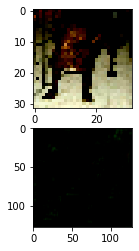

epoch=2--3968 / 3969--d_loss=0.4823678135871887642

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


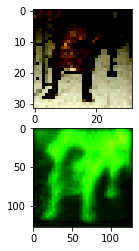

epoch=3--3968 / 3969--d_loss=0.49916654825210575

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


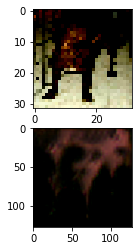

epoch=4--3968 / 3969--d_loss=0.53385597467422493

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


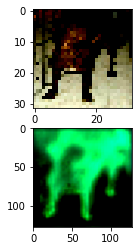

epoch=5--3968 / 3969--d_loss=0.24744644761085514

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


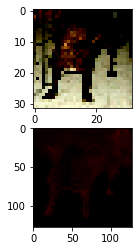

epoch=6--3968 / 3969--d_loss=0.49059671163558965

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


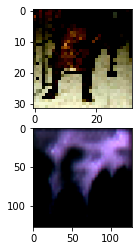

epoch=7--3968 / 3969--d_loss=0.62242913246154796

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


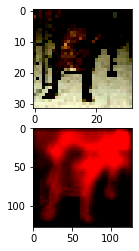

epoch=8--3968 / 3969--d_loss=0.59061408042907714

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


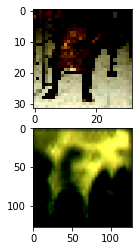

epoch=9--3968 / 3969--d_loss=0.5191771984100342

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


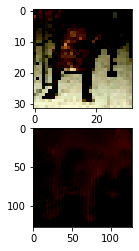

epoch=10--3968 / 3969--d_loss=0.72071719169616777

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


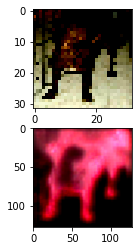

epoch=11--3968 / 3969--d_loss=0.6120240688323975

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


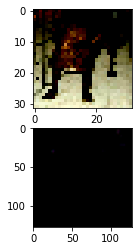

epoch=12--3968 / 3969--d_loss=0.63721573352813723

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


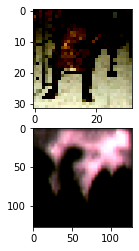

epoch=13--3968 / 3969--d_loss=0.6715112328529358

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


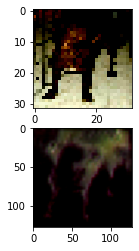

epoch=14--3968 / 3969--d_loss=0.5594645738601685

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


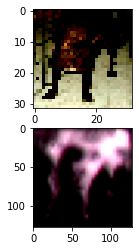

epoch=15--3968 / 3969--d_loss=0.74177694320678714

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


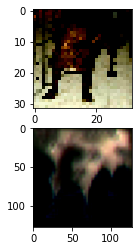

epoch=16--3968 / 3969--d_loss=0.6217199563980103

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


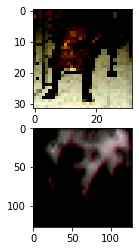

epoch=17--3968 / 3969--d_loss=0.70439898967742925

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


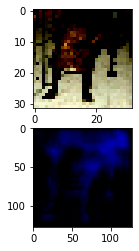

epoch=18--3968 / 3969--d_loss=0.57865762710571297

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


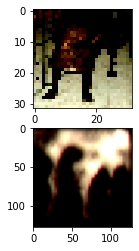

epoch=19--3968 / 3969--d_loss=0.51793068647384646

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


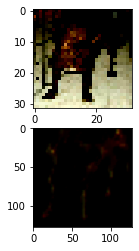

epoch=20--3968 / 3969--d_loss=0.56770759820938114

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


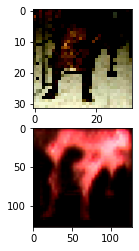

epoch=21--3968 / 3969--d_loss=0.58163249492645263

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


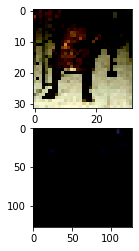

epoch=22--3968 / 3969--d_loss=0.45291587710380554

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


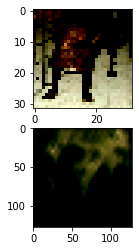

epoch=23--3968 / 3969--d_loss=0.73290598392486573

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


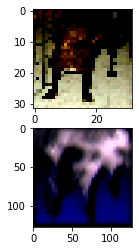

epoch=24--3968 / 3969--d_loss=0.57281726598739627

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


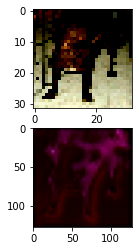

epoch=25--3968 / 3969--d_loss=0.19576773047447205

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


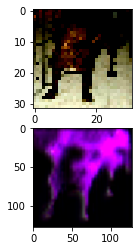

epoch=26--3968 / 3969--d_loss=0.41357803344726567

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


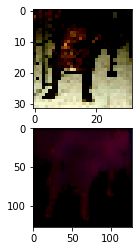

epoch=27--3968 / 3969--d_loss=0.35841923952102664

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


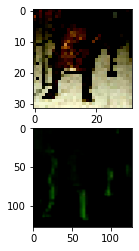

epoch=28--3968 / 3969--d_loss=0.6184893846511841602

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


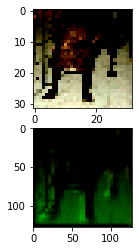

epoch=29--3968 / 3969--d_loss=0.56586122512817384

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


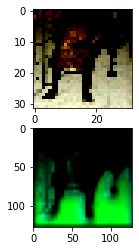

epoch=30--3968 / 3969--d_loss=0.33595138788223267

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


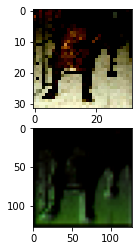

epoch=31--3968 / 3969--d_loss=0.71752548217773445

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


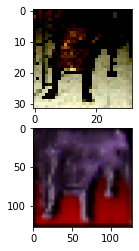

epoch=32--3968 / 3969--d_loss=0.47623240947723397

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


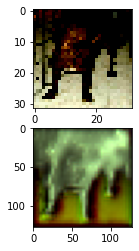

epoch=33--3968 / 3969--d_loss=0.6762925386428833

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


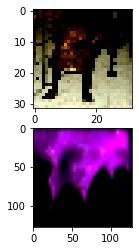

epoch=34--3968 / 3969--d_loss=0.74779021739959727

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


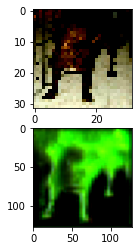

epoch=35--3968 / 3969--d_loss=0.6876903772354126

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


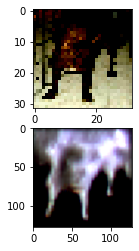

epoch=36--3968 / 3969--d_loss=0.8585548400878906

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


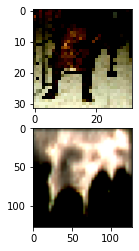

epoch=37--3968 / 3969--d_loss=0.6509622335433962

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


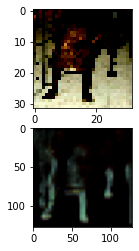

epoch=38--3968 / 3969--d_loss=0.50161373615264894

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


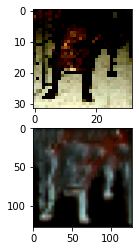

epoch=39--3968 / 3969--d_loss=0.67263638973236086

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


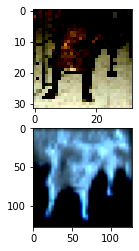

epoch=40--3968 / 3969--d_loss=0.6264441609382629

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


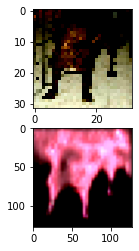

epoch=41--3968 / 3969--d_loss=0.6411812901496887

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


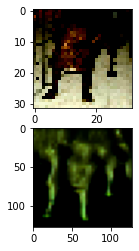

epoch=42--3968 / 3969--d_loss=0.6413701176643372

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


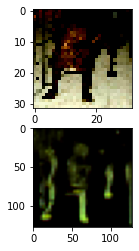

epoch=43--3968 / 3969--d_loss=0.56631791591644294

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


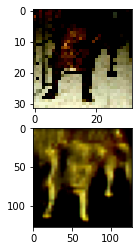

epoch=44--3968 / 3969--d_loss=0.6769894361495972

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


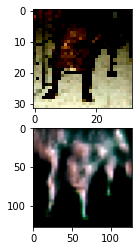

epoch=45--3968 / 3969--d_loss=0.7498161196708679

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


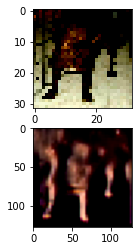

epoch=46--3968 / 3969--d_loss=0.7243081331253052

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


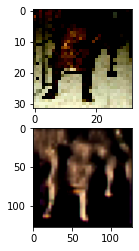

epoch=47--3968 / 3969--d_loss=0.5806404352188111

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


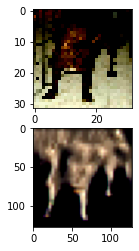

epoch=48--3968 / 3969--d_loss=0.6605809330940247

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


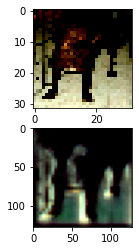

epoch=49--256 / 3969--d_loss=0.6714550256729126

KeyboardInterrupt: 

In [89]:
def train():
    epochs = 50
    batch_size = 64
    test_img = cv2.cvtColor(cv2.resize(cv2.imread('../data/training_set/dogs/dog.1.jpg', cv2.IMREAD_COLOR), (32, 32), cv2.INTER_LINEAR), cv2.COLOR_BGR2RGB)
    test_img = img_to_one(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    for epoch in range(1, epochs + 1):
        for hr_data, lr_data, info in data_loader('../data/training_set/cats', batch_size):
            d_loss, g_loss = train_step(hr_data, lr_data)
            print(f'\r{epoch=}--{info}--d_loss={d_loss.numpy()}',
                  end='', flush=True)
        print()

        gen_pic = gen(test_img)
        show_pic(test_img, gen_pic)

train()